# Question 4

First I import the needed libraries as below:

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
from einops import rearrange
from tqdm import tqdm

In [2]:
!pip install einops

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 210.6 kB/s eta 0:00:00


Next, I load the data using PyTorch. I use transforms to convert the images into PyTorch tensors,
and also normalize the tensor image with mean and standard deviation (0.5, 0.5). I then create
instances of the FashionMNIST dataset for training and testing, and create data loaders for the
train and test sets using batch size of 64

In [4]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
train_data = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
dataloader_train = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
test_data = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)
dataloader_test = torch.utils.data.DataLoader(test_data, batch_size=64, shuffle=False)

100%|██████████| 26421880/26421880 [00:02<00:00, 10178166.83it/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 171639.11it/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 3201888.46it/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 20142049.43it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



Next, in the following cells I define modules to

I define this patch_embed class which converts an input image into a sequence of patches (with patch size equal to 4, as specified in the question), where each patch is embedded into a lower-dimensional space, and then fed into a transformer-based model for image classification.

In [5]:
class patch_embed(nn.Module):
    def __init__(self, size_input=28, patch_size=4, in_channels=1, embed_dim=64):
        super(patch_embed, self).__init__()
        self.size_input = size_input
        self.patch_size = patch_size
        self.embed = nn.Conv2d(in_channels, embed_dim, kernel_size=patch_size, stride=patch_size)


    def forward(self, data):
        # Apply a 2D convolution, dividing the image into patches and embedding each patch into a lower-dimensional space.
        data = self.embed(data)
        data = data.permute(0, 2, 3, 1)
        data = data.contiguous().view(data.size(0), -1, data.size(-1))
        return data

Next, I implement the multi-head attention mechanism as below:

In [6]:
class Multi_Head_Attention(nn.Module):
    def __init__(self, embed_dim=64, num_heads=4):
        super(Multi_Head_Attention, self).__init__()

        # Initializing the number of heads
        self.num_heads = num_heads

        # Linear transformations for query, key, and value
        self.query = nn.Linear(embed_dim, embed_dim)
        self.key = nn.Linear(embed_dim, embed_dim)
        self.value = nn.Linear(embed_dim, embed_dim)

        # Calculating the dimensionality of each head
        self.head_dim = embed_dim // num_heads
        self.scale = self.head_dim ** -0.5

        # Final linear transformation
        self.final_FC = nn.Linear(embed_dim, embed_dim)

    def forward(self, query, key, value):

        # Linear transformationa and reshaping the tensors to split it into multiple heads
        # for query, key, and value

        Q = self.query(query)
        Q_shape = (Q.size(0), self.num_heads, Q.size(1), self.head_dim)
        Q = Q.view(*Q_shape)


        K = self.key(key)
        K_shape = (K.size(0), self.num_heads, K.size(1), self.head_dim)
        K = K.view(*K_shape)


        V = self.value(value)
        V_shape = (V.size(0), self.num_heads, V.size(1), self.head_dim)
        V = V.view(*V_shape)

        # Computing attention scores and applying softmax to get attention weights
        summation = torch.einsum('bhid,bhjd->bhij', Q, K) * self.scale
        attention_score = F.softmax(summation, dim=-1)

        # The weighted sum of the value vectors
        result = torch.einsum('bhij,bhjd->bhid', attention_score, V)

        # Reshaping the result back to the original shape and applying final linear transformation
        result = rearrange(result, 'b h n d -> b n (h d)')
        result = self.final_FC(result)
        return result

Next, using the above module, I implement a Transformer class:

In [7]:
class Transformer_(nn.Module):
    def __init__(self, embed_dim=64, num_heads=4, hidden_dim=64):
        super(Transformer_, self).__init__()

        # applying the multi-head attention mechanism
        self.attention = Multi_Head_Attention(embed_dim, num_heads)

        # Layer normalization after the attention mechanism
        self.norm_attention = nn.LayerNorm(embed_dim)

        # MLP for each position in the sequence
        self.mlp = nn.Sequential(
            nn.Linear(embed_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, embed_dim)
        )

        # Layer normalization after the MLP
        self.norm_mlp = nn.LayerNorm(embed_dim)

    def forward(self, data):
        attention_output = self.attention(data, data, data)

        # Layer normalization and residual connection
        data = self.norm_attention(data + attention_output)

        nn_output = self.mlp(data)

        # Layer normalization and residual connection
        data = self.norm_mlp(data + nn_output)

        return data

Finally, I define the vision transformer module as below, using 6 ViT layers and 4 heads, with 10 output classes for the classification task:

In [8]:
class Vision_Transformer(nn.Module):
    def __init__(self, size_input = 28, patch_size=4, in_channels=1, embed_dim=64, num_ViT_layers=6, num_heads=4, hidden_dim=64, num_classes=10):
        super(Vision_Transformer, self).__init__()

        # Patch embedding layer using the defined module
        self.patch_embedding = patch_embed(size_input, patch_size, in_channels, embed_dim)

        # List of transformer blocks
        self.transformer_blocks = nn.ModuleList([
            Transformer_(embed_dim, num_heads, hidden_dim) for _ in range(num_ViT_layers)])

        # Final linear layer for classification
        self.final_output = nn.Linear(embed_dim, num_classes)

    def forward(self, x):
        x = self.patch_embedding(x)

        # Passing through transformer blocks
        for transformer_block in self.transformer_blocks:
            x = transformer_block(x)

        # Taking the output of the first token in the final classification layer
        x = self.final_output(x[:, 0])
        return x

Then, I instantiate ViT model as below:

In [9]:
model = Vision_Transformer(size_input=28, patch_size=4, in_channels=1, embed_dim=64, num_ViT_layers=6, num_heads=4)

We can see the model architecture as below:

In [10]:
print(model)

Vision_Transformer(
  (patch_embedding): patch_embed(
    (embed): Conv2d(1, 64, kernel_size=(4, 4), stride=(4, 4))
  )
  (transformer_blocks): ModuleList(
    (0-5): 6 x Transformer_(
      (attention): Multi_Head_Attention(
        (query): Linear(in_features=64, out_features=64, bias=True)
        (key): Linear(in_features=64, out_features=64, bias=True)
        (value): Linear(in_features=64, out_features=64, bias=True)
        (final_FC): Linear(in_features=64, out_features=64, bias=True)
      )
      (norm_attention): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (mlp): Sequential(
        (0): Linear(in_features=64, out_features=64, bias=True)
        (1): ReLU()
        (2): Linear(in_features=64, out_features=64, bias=True)
      )
      (norm_mlp): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    )
  )
  (final_output): Linear(in_features=64, out_features=10, bias=True)
)


Next, I define the loss function and optimizer.  I use the cross entropy loss function since it is suitable for multi-class classifcation tasks. (It combines log of the softmax function and Negative Log Likelihood loss in a single class.) I also use the Adam optimizer which is a variant of stochastic
gradient descent. I set the learning rate to 0.001.

In [11]:
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

Next I defne the training loop, where this algorithm is iterated for 10 epochs. After each epoch, it evaluates the model performance on both training and test datasets. For test dataset, it calculates the test loss without performing backpropagation.

In [22]:
train_losses = []
test_losses = []

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

for epoch in range(11):
    train_loss = test_loss = 0

    for idx, data in enumerate(tqdm(dataloader_train)):
        inputs, target = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()

    # Forward pass to get the predictions from the model.
        predicted = model(inputs)

    # Calculates the loss between predicted and target values using the defined loss function.
        loss = loss_function(predicted, target)

    # Backpropagating the gradients and computing the gradient of the loss with respect to the parameters.
        loss.backward()

    # Updates the model parameters
        optimizer.step()
        train_loss += loss.item()

    with torch.no_grad():
        for test_data in dataloader_test:
            input, target = test_data
            predicted = model(input.to(device))
            test_loss += (loss_function(predicted, target.to(device))).item()

    train_losses.append(train_loss / len(dataloader_train))
    test_losses.append(test_loss / len(dataloader_test))

    print('for epoch number {}, Loss_train: {:.3f}, Loss_test: {:.3f}'.format(epoch+1, train_loss / len(dataloader_train), test_loss / len(dataloader_test)))

100%|██████████| 938/938 [00:31<00:00, 29.93it/s]


for epoch number 1, Loss_train: 0.207, Loss_test: 0.339


100%|██████████| 938/938 [00:29<00:00, 32.22it/s]


for epoch number 2, Loss_train: 0.198, Loss_test: 0.313


100%|██████████| 938/938 [00:29<00:00, 31.74it/s]


for epoch number 3, Loss_train: 0.189, Loss_test: 0.325


100%|██████████| 938/938 [00:29<00:00, 32.19it/s]


for epoch number 4, Loss_train: 0.179, Loss_test: 0.315


100%|██████████| 938/938 [00:29<00:00, 32.33it/s]


for epoch number 5, Loss_train: 0.166, Loss_test: 0.324


100%|██████████| 938/938 [00:29<00:00, 31.55it/s]


for epoch number 6, Loss_train: 0.161, Loss_test: 0.333


100%|██████████| 938/938 [00:29<00:00, 32.26it/s]


for epoch number 7, Loss_train: 0.154, Loss_test: 0.349


100%|██████████| 938/938 [00:29<00:00, 32.23it/s]


for epoch number 8, Loss_train: 0.145, Loss_test: 0.316


100%|██████████| 938/938 [00:29<00:00, 31.51it/s]


for epoch number 9, Loss_train: 0.140, Loss_test: 0.342


100%|██████████| 938/938 [00:29<00:00, 31.50it/s]


for epoch number 10, Loss_train: 0.130, Loss_test: 0.345


100%|██████████| 938/938 [00:29<00:00, 32.00it/s]


for epoch number 11, Loss_train: 0.128, Loss_test: 0.345


Reporting the test accuracy on the fnal model, and plotting the train_losses and test_losses that
were computed during training:

In [23]:
from sklearn.metrics import accuracy_score

predicted_ = []
ground_truth = []
with torch.no_grad():
    for data in dataloader_test:
        images, target = data
        predicted = model(images.to(device))
        idx, predicted = torch.max(predicted.data, 1)
        predicted_.extend(predicted.tolist())
        ground_truth.extend(target.tolist())

accuracy = accuracy_score(ground_truth, predicted_)
print('Accuracy on test set: {:.2f}%'.format(100 * accuracy))

Accuracy on test set: 89.33%


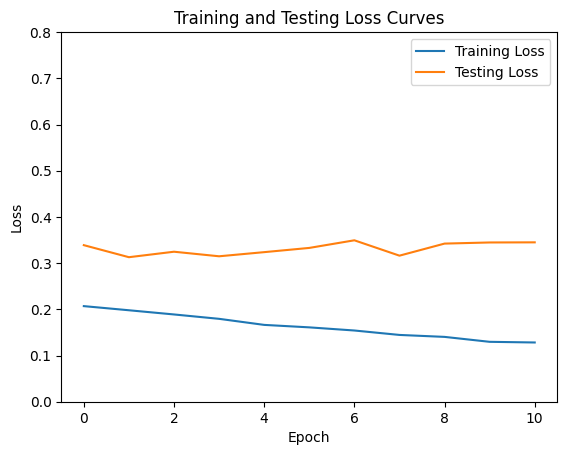

In [26]:
import matplotlib.pyplot as plt

plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Testing Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Testing Loss Curves')
plt.ylim([0,0.8])
plt.legend()
plt.show()

Next, I defne a function to plot images with predicted probabilities as below. Each subplot shows
an input image, its corresponding label (which are computed using softmax function), and the
predicted probabilities for each class. I visualize the results on 3 test samples.

In [27]:
def plot_results(x, y, pred_p, num_data=3):
    fig, axes = plt.subplots(num_data, 2, figsize=(9, 3*num_data))

    for i, (data, ground_truth, prob) in enumerate(zip(x[:num_data], y[:num_data], pred_p[:num_data])):
        axes[i, 0].imshow(data.squeeze(), cmap='gray')
        axes[i, 0].set_title(f'Ground Truth class: {ground_truth}')
        axes[i, 1].bar(np.arange(len(prob)), prob)
        axes[i, 1].set_xticks(np.arange(len(prob)))
        axes[i, 1].set_title('Probabilities')

    plt.show()

Predict on test dataset

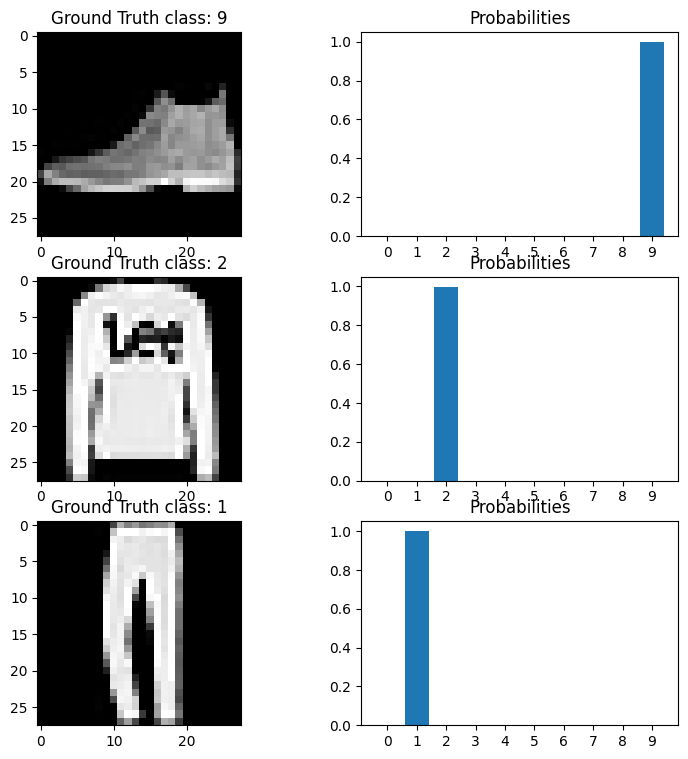

In [32]:
import numpy as np

model.eval()
x_test, y_test = next(iter(dataloader_test))
with torch.no_grad():
    predicted = model(x_test.to(device))
    predicted_probs = torch.softmax(predicted, dim=1)

plot_results(x_test.cpu().detach().numpy(), y_test.cpu().detach().numpy(), predicted_probs.cpu().detach().numpy())

As we can see, the model predicts the true label with high probability.